# Things to do
- Add humidity column
- Add lag data (lag-2) for past and future
- Foward fill and back fill
- Deal with outliers
- Choose features columns (bit masking bruteforce)
- Modeling for test
- Modeling for forecast

### Rút kinh nghiệm sau vài lần chọn features cho model:  
    - Cột cbwd và thứ trong tuần không quá ảnh hưởng đến model nên không dùng nữa
    - Cột Ir và Is không ảnh hưởng nhiều đến model
    - Cột pres không ảnh hưởng nhiều dến model

In [1]:
import pandas as pd
import numpy as np
from math import exp, isnan
from datetime import datetime
from matplotlib import pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split

In [2]:
plt.rcParams["figure.figsize"] = 15, 10
plt.style.use('ggplot')

In [3]:
df = pd.read_csv('data.csv')
df

,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
0,1,2010,1,1,0,NaN,-21,-11.0,1021.0,NW,1.79,0,0
1,2,2010,1,1,1,NaN,-21,-12.0,1020.0,NW,4.92,0,0
2,3,2010,1,1,2,NaN,-21,-11.0,1019.0,NW,6.71,0,0
3,4,2010,1,1,3,NaN,-21,-14.0,1019.0,NW,9.84,0,0
4,5,2010,1,1,4,NaN,-20,-12.0,1018.0,NW,12.97,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
43819,43820,2014,12,31,19,8.0,-23,-2.0,1034.0,NW,231.97,0,0
43820,43821,2014,12,31,20,10.0,-22,-3.0,1034.0,NW,237.78,0,0
43821,43822,2014,12,31,21,10.0,-22,-3.0,1034.0,NW,242.70,0,0
43822,43823,2014,12,31,22,8.0,-22,-4.0,1034.0,NW,246.72,0,0


## Add humidity column

In [4]:
def cal(temp, dewp):
    return 100*(exp((17.625*dewp)/(243.04+dewp))/exp((17.625*temp)/(243.04+temp)))
df['hum'] = [cal(temp, dewp) for temp, dewp in zip(df['TEMP'], df['DEWP'])]

## Lag data

In [5]:
def add_lags(dataframe):
    need_shift = ['pm2.5', 'DEWP', 'TEMP', 'Iws']
    for var in need_shift:
        for i in range(1, 3):
            key = var + '_' + str(i)
            dataframe[key + '_past'] = dataframe[var].shift(periods=i)
            dataframe[key + '_future'] = dataframe[var].shift(periods=-i)
    return dataframe

In [6]:
df = add_lags(df.copy())

## Fill NaN with LOCF and LOCB


In [7]:
df['pm2.5'].isna().sum()

2067

In [8]:
df.fillna(method='ffill', inplace=True)

In [9]:
df.fillna(method='backfill', inplace=True)

In [10]:
df.isna()

,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir,hum,pm2.5_1_past,pm2.5_1_future,pm2.5_2_past,pm2.5_2_future,DEWP_1_past,DEWP_1_future,DEWP_2_past,DEWP_2_future,TEMP_1_past,TEMP_1_future,TEMP_2_past,TEMP_2_future,Iws_1_past,Iws_1_future,Iws_2_past,Iws_2_future
0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43819,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
43820,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
43821,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
43822,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False


## Outliers

In [11]:
df['datetime'] = pd.to_datetime(df[['year', 'month', 'day', 'hour']])

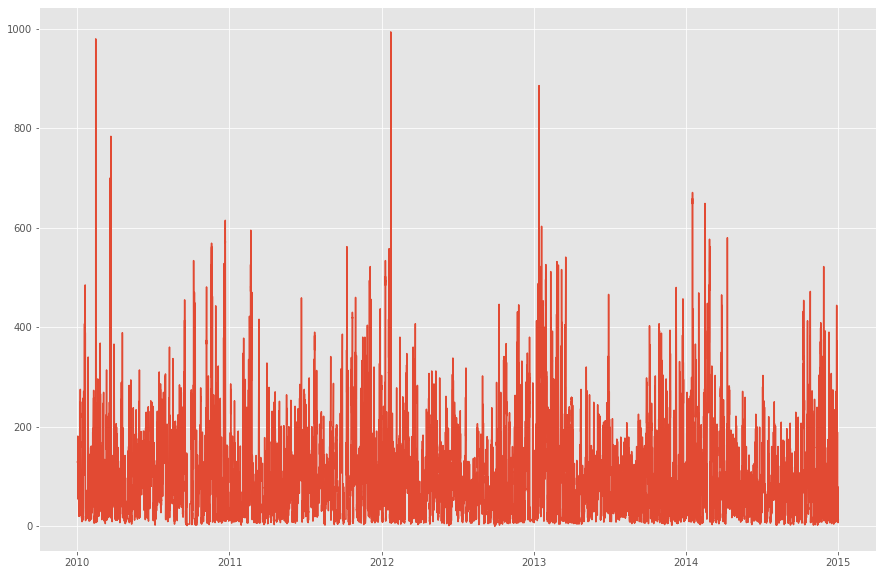

In [12]:
plt.plot(df['datetime'], df['pm2.5'])
plt.show()

In [13]:
df = df[df['pm2.5'] <= 600]

In [14]:
df.columns

Index(['No', 'year', 'month', 'day', 'hour', 'pm2.5', 'DEWP', 'TEMP', 'PRES',
       'cbwd', 'Iws', 'Is', 'Ir', 'hum', 'pm2.5_1_past', 'pm2.5_1_future',
       'pm2.5_2_past', 'pm2.5_2_future', 'DEWP_1_past', 'DEWP_1_future',
       'DEWP_2_past', 'DEWP_2_future', 'TEMP_1_past', 'TEMP_1_future',
       'TEMP_2_past', 'TEMP_2_future', 'Iws_1_past', 'Iws_1_future',
       'Iws_2_past', 'Iws_2_future', 'datetime'],
      dtype='object')

In [15]:
need_viz = ['pm2.5', 'DEWP', 'TEMP', 'PRES', 'cbwd', 'Iws', 'Is', 'Ir', 'hum']

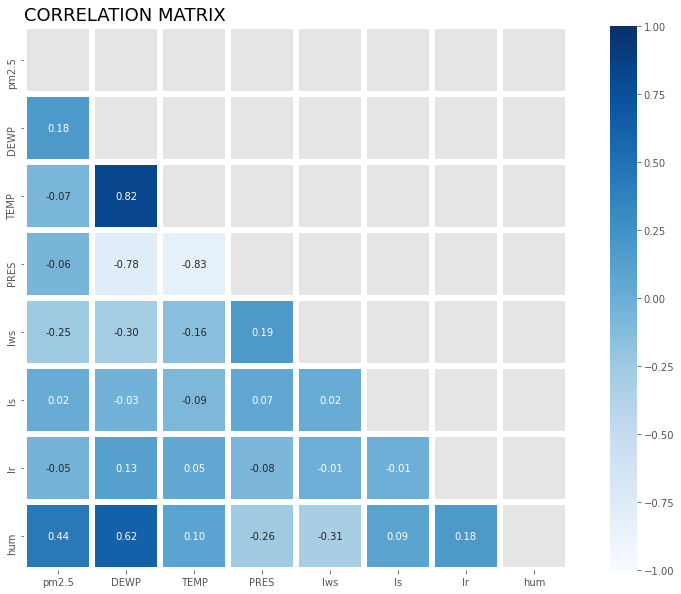

In [16]:
import seaborn as sns
data = df[need_viz].corr()
mask = np.zeros_like(data)
mask[np.triu_indices_from(mask)] = True

ax = sns.heatmap(data, mask=mask, annot=True, fmt='.2f', linewidth=5, cmap='Blues', vmin=-1, vmax=1, square=True)
plt.title('CORRELATION MATRIX', loc='left', fontsize=18)
plt.show()

## Select features and predicts columns

In [17]:
# lấy những cột mà mình nghĩ nó có tác động tốt đến model
# bỏ cột cbwd
all_features = df.columns.to_list()
all_features = all_features[8:9] + all_features[10:]
print(all_features, len(all_features))

['PRES', 'Iws', 'Is', 'Ir', 'hum', 'pm2.5_1_past', 'pm2.5_1_future', 'pm2.5_2_past', 'pm2.5_2_future', 'DEWP_1_past', 'DEWP_1_future', 'DEWP_2_past', 'DEWP_2_future', 'TEMP_1_past', 'TEMP_1_future', 'TEMP_2_past', 'TEMP_2_future', 'Iws_1_past', 'Iws_1_future', 'Iws_2_past', 'Iws_2_future', 'datetime'] 22


In [18]:
predicts = ['pm2.5', 'DEWP', 'TEMP']

#### Using binary bruteforce method
- loop over 2 ^ len(features)
- with each number, consider the 1 bit, select index at 1 bit => we have a list
- with that list, get X and y using df[list]
- throw into the model, get the score with test dataset
- update the best score with best list

In [19]:
# best_score = 0
# best_features = []
# len_features = len(all_features)
# for mask in range(2 ** len_features):
#     tmp_list = []
#     for index in range(len_features):
#         if (mask & index):
#             tmp_list.append(all_features[index])
#     # list không rỗng
#     if tmp_list:
#         Xtrain, Xtest, ytrain, ytest = train_test_split(df[tmp_list], df[predicts])
#         foo = RandomForestRegressor().fit(Xtrain, ytrain)
#         score = r2_score(foo.predict(Xtest), ytest)
#         if (score > best_score):
#             best_score = score
#             best_features = tmp_list
#             print(best_score, best_features)

In [20]:
# Có thể ngắt ô trên khi cảm thấy điểm đủ tốt

In [21]:
best_features = ['Iws', 'Ir', 'hum', 'pm2.5_1_past', 
                 'pm2.5_1_future', 'pm2.5_2_past', 'pm2.5_2_future', 'DEWP_1_past', 
                 'DEWP_1_future', 'DEWP_2_past', 'DEWP_2_future', 'TEMP_1_past', 
                 'TEMP_1_future', 'TEMP_2_past', 'TEMP_2_future', 'Iws_1_past', 
                 'Iws_1_future', 'Iws_2_past', 'Iws_2_future']

In [22]:
print(best_features)

['Iws', 'Ir', 'hum', 'pm2.5_1_past', 'pm2.5_1_future', 'pm2.5_2_past', 'pm2.5_2_future', 'DEWP_1_past', 'DEWP_1_future', 'DEWP_2_past', 'DEWP_2_future', 'TEMP_1_past', 'TEMP_1_future', 'TEMP_2_past', 'TEMP_2_future', 'Iws_1_past', 'Iws_1_future', 'Iws_2_past', 'Iws_2_future']


In [23]:
features = best_features

In [24]:
X = df[features]
y = df[predicts].values
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=1/4)

In [25]:
def cal_error(model, X, y):
    predict = model.predict(X)
    data = [0] * 3
    for i in range(len(predict)):
        for j in range(3):
            data[j] += abs(predict[i][j] - y[i][j])
    data = [i / len(predict) for i in data]
    ret = pd.DataFrame(np.asarray(data).reshape(3, 1), columns=['Error'])
    ret.index = ['pm2.5', 'dewp', 'temp']
    return ret

In [26]:
def score_model(model, X, y):
    predict = model.predict(X)
    print('R^2 score:', r2_score(predict, y))
    print('Mean Absolute Error:', mean_absolute_error(predict, y))
    print(cal_error(model, X, y))

In [27]:
def important_features(model, features):
    foo = pd.Series(model.feature_importances_, index=features)
    foo.nlargest(100).plot(kind='barh')
    plt.show()

## Modeling

In [28]:
# class Modeling:
#     def __init__(self, df, features, predicts):
#         self.X = df[features]
#         self.y = df[predicts].values
#         self.Xtrain, self.Xtest, self.ytrain, self.ytest = train_test_split(X, y, test_size=1/3)
    
#     def train():
        
#     def predict(self, data):
#         return self.model.predict(data)
    
#     def cal_error(self):
#         predict = predict()
#         data = [0] * 3
#         for i in range(len(predict)):
#             for j in range(3):
#                 data[j] += abs(predict[i][j] - y[i][j])
#         for i in range(3):
#             data[i] /= len(predict)
#         table = pd.DataFrame({})
#         return (data[0], data[1], data[2])
    
#     def score(self, model, X, y):
#         predict = model.predict(X)
#         print('R^2 score:', r2_score(predict, y))
#         print('Mean Absolute Error:', mean_absolute_error(predict, y))
#         print(cal_error(model, X, y))

#     def important_features(model, features):
#         foo = pd.Series(model.feature_importances_, index=features)
#         foo.nlargest(100).plot(kind='barh')
#         plt.show()

In [29]:
# testModel = Modeling(df, features, predicts) 

In [30]:
# testModel.score()

### Split train and test data for testing

#### Some parameters should be tunning
- n_estimators = 1000 (trees)
- oob_score (yes)

In [31]:
random_forest_test = RandomForestRegressor(n_estimators=1000, oob_score=True)

# use partial dataset
random_forest_test.fit(Xtrain, ytrain)
random_forest_test.score(Xtrain, ytrain)

/usr/local/lib/python3.6/dist-packages/sklearn/base.py:434: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


0.9960966589602529

In [32]:
score_model(random_forest_test, Xtest, ytest)

R^2 score: 0.9823766112839266
Mean Absolute Error: 3.4358854889782044
          Error
pm2.5  8.448783
dewp   0.890808
temp   0.968065


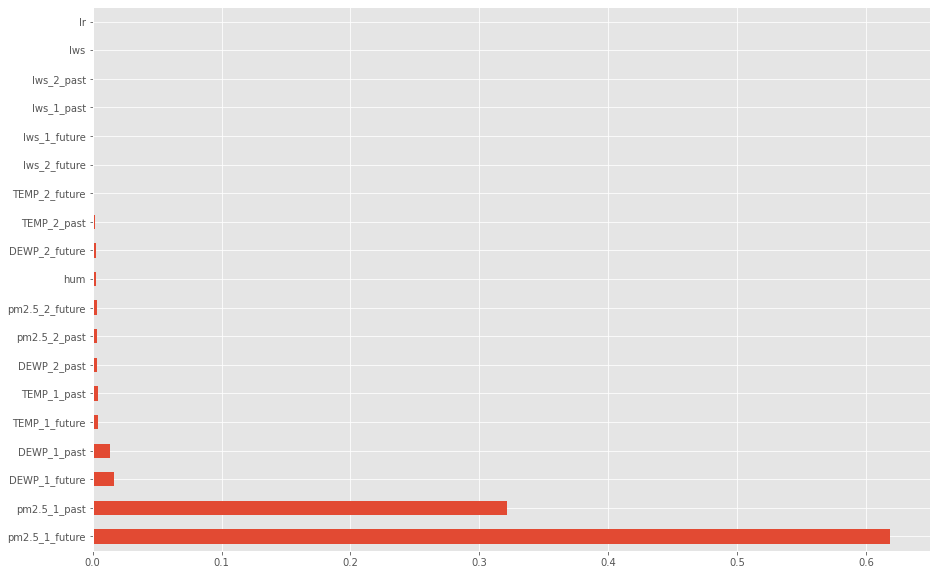

In [33]:
important_features(random_forest_test, features)

In [34]:
def make_plot(key, num):
  foo = {'pm2.5': 0, 'DEWP': 1, 'TEMP': 2}

  predict_10_hour = random_forest_test.predict(df[features].tail(num))

  dic = dict()
  for i in range(3):
    dic[i] = [j[i] for j in predict_10_hour]

  pred = pd.DataFrame(dic[foo[key]])
  pred['datetime'] = list(df.tail(num)['datetime'])
  pred = pred.set_index('datetime')

  foo = pd.DataFrame(df.tail(num)[['datetime', key]].copy())
  foo = foo.set_index('datetime')

  plt.plot(pred, label='Predicts')
  plt.plot(foo, label='Actual')

  plt.legend(loc='best')
  plt.title('Actual and Predicts value plot of ' + key + ' last ' + str(num) + ' hours')
  plt.show()

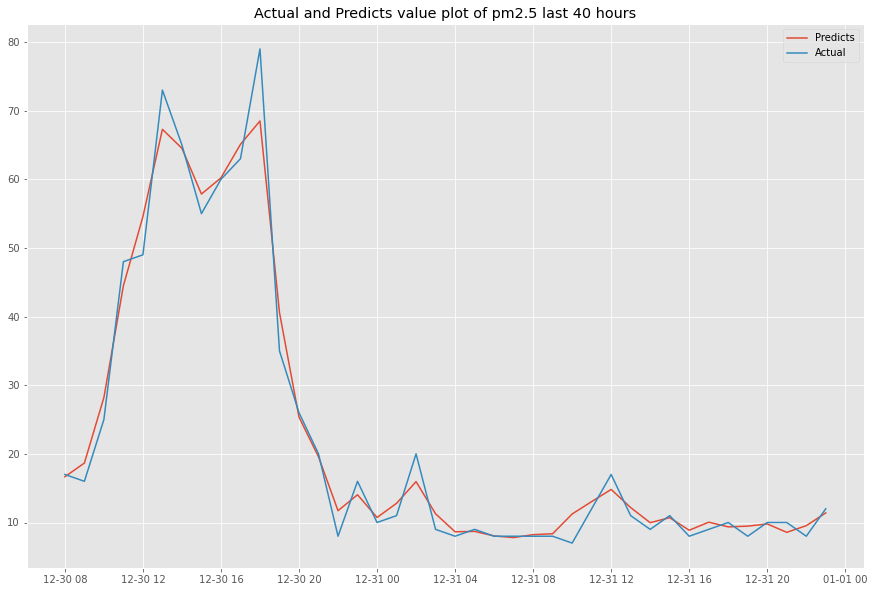

In [35]:
make_plot('pm2.5', 40)

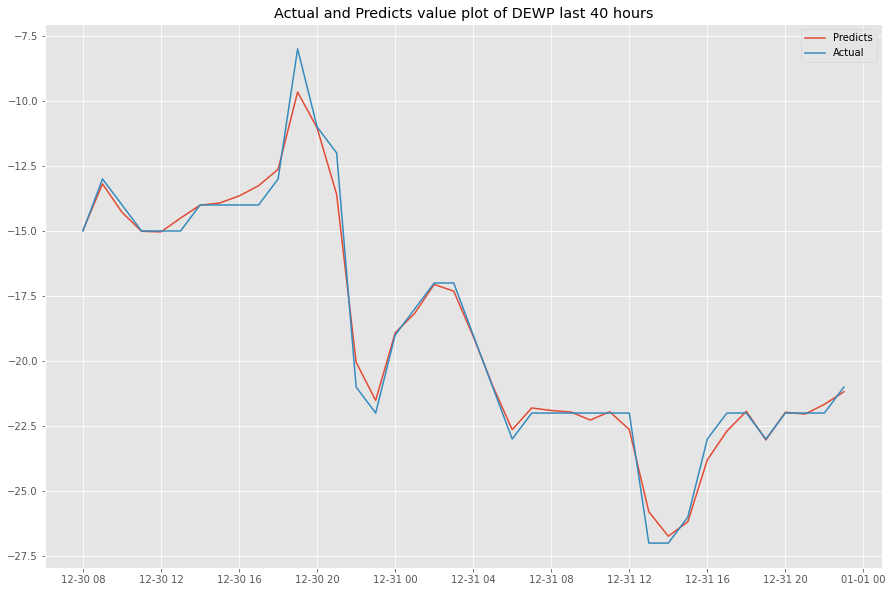

In [36]:
make_plot('DEWP', 40)

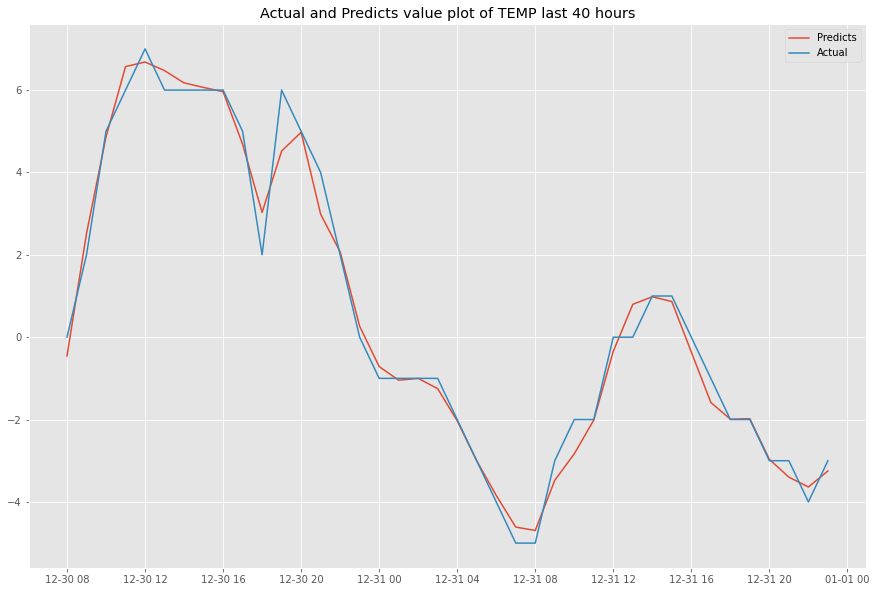

In [37]:
make_plot('TEMP', 40)

### Use whole dataset for modeling, use for forecast

In [38]:
random_forest = RandomForestRegressor(n_estimators=1000, oob_score=True)
random_forest.fit(X, y)
random_forest.score(X, y)

/usr/local/lib/python3.6/dist-packages/sklearn/base.py:434: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


0.9961344395344198

## Predict for next 6 hours

In [39]:
add_lags(df.copy())

,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir,hum,pm2.5_1_past,pm2.5_1_future,pm2.5_2_past,pm2.5_2_future,DEWP_1_past,DEWP_1_future,DEWP_2_past,DEWP_2_future,TEMP_1_past,TEMP_1_future,TEMP_2_past,TEMP_2_future,Iws_1_past,Iws_1_future,Iws_2_past,Iws_2_future,datetime
0,1,2010,1,1,0,129.0,-21,-11.0,1021.0,NW,1.79,0,0,43.543692,NaN,129.0,NaN,129.0,NaN,-21.0,NaN,-21.0,NaN,-12.0,NaN,-11.0,NaN,4.92,NaN,6.71,2010-01-01 00:00:00
1,2,2010,1,1,1,129.0,-21,-12.0,1020.0,NW,4.92,0,0,47.165689,129.0,129.0,NaN,129.0,-21.0,-21.0,NaN,-21.0,-11.0,-11.0,NaN,-14.0,1.79,6.71,NaN,9.84,2010-01-01 01:00:00
2,3,2010,1,1,2,129.0,-21,-11.0,1019.0,NW,6.71,0,0,43.543692,129.0,129.0,129.0,129.0,-21.0,-21.0,-21.0,-20.0,-12.0,-14.0,-11.0,-12.0,4.92,9.84,1.79,12.97,2010-01-01 02:00:00
3,4,2010,1,1,3,129.0,-21,-14.0,1019.0,NW,9.84,0,0,55.454538,129.0,129.0,129.0,129.0,-21.0,-20.0,-21.0,-19.0,-11.0,-12.0,-12.0,-10.0,6.71,12.97,4.92,16.10,2010-01-01 03:00:00
4,5,2010,1,1,4,129.0,-20,-12.0,1018.0,NW,12.97,0,0,51.426936,129.0,129.0,129.0,129.0,-21.0,-19.0,-21.0,-19.0,-14.0,-10.0,-11.0,-9.0,9.84,16.10,6.71,19.23,2010-01-01 04:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43819,43820,2014,12,31,19,8.0,-23,-2.0,1034.0,NW,231.97,0,0,18.340886,10.0,10.0,9.0,10.0,-22.0,-22.0,-22.0,-22.0,-2.0,-3.0,-1.0,-3.0,226.16,237.78,221.24,242.70,2014-12-31 19:00:00
43820,43821,2014,12,31,20,10.0,-22,-3.0,1034.0,NW,237.78,0,0,21.568601,8.0,10.0,10.0,8.0,-23.0,-22.0,-22.0,-22.0,-2.0,-3.0,-2.0,-4.0,231.97,242.70,226.16,246.72,2014-12-31 20:00:00
43821,43822,2014,12,31,21,10.0,-22,-3.0,1034.0,NW,242.70,0,0,21.568601,10.0,8.0,8.0,12.0,-22.0,-22.0,-23.0,-21.0,-3.0,-4.0,-2.0,-3.0,237.78,246.72,231.97,249.85,2014-12-31 21:00:00
43822,43823,2014,12,31,22,8.0,-22,-4.0,1034.0,NW,246.72,0,0,23.240409,10.0,12.0,10.0,NaN,-22.0,-21.0,-22.0,NaN,-3.0,-3.0,-3.0,NaN,242.70,249.85,237.78,NaN,2014-12-31 22:00:00


In [40]:
df[features].tail(1)

,Iws,Ir,hum,pm2.5_1_past,pm2.5_1_future,pm2.5_2_past,pm2.5_2_future,DEWP_1_past,DEWP_1_future,DEWP_2_past,DEWP_2_future,TEMP_1_past,TEMP_1_future,TEMP_2_past,TEMP_2_future,Iws_1_past,Iws_1_future,Iws_2_past,Iws_2_future
43823,249.85,0,23.535657,8.0,12.0,10.0,12.0,-22.0,-21.0,-22.0,-21.0,-4.0,-3.0,-3.0,-3.0,246.72,249.85,242.7,249.85


In [41]:
for i in range(6):
    df.fillna(method='ffill', inplace=True)
    tail = pd.concat([df.tail(1)], ignore_index=True)
    tail.loc[:, ['day', 'month', 'year', 'hour']] = [1, 1, 2015, i]
    df = pd.concat([df, tail], ignore_index=True)
    df.loc[len(df) - 1:, predicts] = random_forest.predict(tail[features])
    df = add_lags(df.copy())

In [42]:
df.tail(6)[['day', 'month', 'year', 'hour'] + predicts]

,day,month,year,hour,pm2.5,DEWP,TEMP
43789,1,1,2015,0,11.119,-21.168,-3.194
43790,1,1,2015,1,11.106,-21.198,-3.317
43791,1,1,2015,2,11.193,-21.033,-3.084
43792,1,1,2015,3,11.204,-21.039,-3.084
43793,1,1,2015,4,11.204,-21.039,-3.084
43794,1,1,2015,5,11.204,-21.039,-3.084


In [43]:
df.tail(10)

,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir,hum,pm2.5_1_past,pm2.5_1_future,pm2.5_2_past,pm2.5_2_future,DEWP_1_past,DEWP_1_future,DEWP_2_past,DEWP_2_future,TEMP_1_past,TEMP_1_future,TEMP_2_past,TEMP_2_future,Iws_1_past,Iws_1_future,Iws_2_past,Iws_2_future,datetime
43785,43821,2014,12,31,20,10.000,-22.000,-3.000,1034.0,NW,237.78,0,0,21.568601,8.000,10.000,10.000,8.000,-23.000,-22.000,-22.000,-22.000,-2.000,-3.000,-2.000,-4.000,231.97,242.70,226.16,246.72,2014-12-31 20:00:00
43786,43822,2014,12,31,21,10.000,-22.000,-3.000,1034.0,NW,242.70,0,0,21.568601,10.000,8.000,8.000,12.000,-22.000,-22.000,-23.000,-21.000,-3.000,-4.000,-2.000,-3.000,237.78,246.72,231.97,249.85,2014-12-31 21:00:00
43787,43823,2014,12,31,22,8.000,-22.000,-4.000,1034.0,NW,246.72,0,0,23.240409,10.000,12.000,10.000,11.119,-22.000,-21.000,-22.000,-21.168,-3.000,-3.000,-3.000,-3.194,242.70,249.85,237.78,249.85,2014-12-31 22:00:00
43788,43824,2014,12,31,23,12.000,-21.000,-3.000,1034.0,NW,249.85,0,0,23.535657,8.000,11.119,10.000,11.106,-22.000,-21.168,-22.000,-21.198,-4.000,-3.194,-3.000,-3.317,246.72,249.85,242.70,249.85,2014-12-31 23:00:00
43789,43824,2015,1,1,0,11.119,-21.168,-3.194,1034.0,NW,249.85,0,0,23.535657,12.000,11.106,8.000,11.193,-21.000,-21.198,-22.000,-21.033,-3.000,-3.317,-4.000,-3.084,249.85,249.85,246.72,249.85,2014-12-31 23:00:00
43790,43824,2015,1,1,1,11.106,-21.198,-3.317,1034.0,NW,249.85,0,0,23.535657,11.119,11.193,12.000,11.204,-21.168,-21.033,-21.000,-21.039,-3.194,-3.084,-3.000,-3.084,249.85,249.85,249.85,249.85,2014-12-31 23:00:00
43791,43824,2015,1,1,2,11.193,-21.033,-3.084,1034.0,NW,249.85,0,0,23.535657,11.106,11.204,11.119,11.204,-21.198,-21.039,-21.168,-21.039,-3.317,-3.084,-3.194,-3.084,249.85,249.85,249.85,249.85,2014-12-31 23:00:00
43792,43824,2015,1,1,3,11.204,-21.039,-3.084,1034.0,NW,249.85,0,0,23.535657,11.193,11.204,11.106,11.204,-21.033,-21.039,-21.198,-21.039,-3.084,-3.084,-3.317,-3.084,249.85,249.85,249.85,249.85,2014-12-31 23:00:00
43793,43824,2015,1,1,4,11.204,-21.039,-3.084,1034.0,NW,249.85,0,0,23.535657,11.204,11.204,11.193,NaN,-21.039,-21.039,-21.033,NaN,-3.084,-3.084,-3.084,NaN,249.85,249.85,249.85,NaN,2014-12-31 23:00:00
43794,43824,2015,1,1,5,11.204,-21.039,-3.084,1034.0,NW,249.85,0,0,23.535657,11.204,NaN,11.204,NaN,-21.039,NaN,-21.039,NaN,-3.084,NaN,-3.084,NaN,249.85,NaN,249.85,NaN,2014-12-31 23:00:00


### Note:
- season
- trend
- statistical models for time serries
- how data transform by times (up or down, low or high)
- past data for weekdays or for pm2.5 last year
- k fold cross validation for time series